In [1]:
# 경로설정
import sys
path = "C:\github/aide-analysis/"
path2 = 'C:\github/aide-analysis/notebook/temp_ljs/Develop/지주리포트Lite/실거래 이상값 제거 연구 및 추론/모듈 및 압축파일 보관 폴더'
sys.path.append(path)
sys.path.append(path2)

import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd())))
# 한글폰트
import os
import matplotlib.pyplot as plt
if os.name =='posix':
    plt.rc('font',family = 'ApplGothic')
else:
    plt.rc('font',family = 'Malgun Gothic')
    
# 경고출력문 제거
import warnings
warnings.filterwarnings("ignore")

# 모듈 import
import pandas as pd
import src
from src.openapi import KakaoLocalAPI as kakao
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from src.sql import DatabaseHandler
from src.temp import *
from datetime import datetime
import datetime
from dateutil.relativedelta import relativedelta
from src.bigquery import BigqueryHandler
import seaborn as sns
import numpy as np
import statistics
from tqdm import tqdm
import config
from core.config import Config
import json
from datetime import datetime
import geopandas as gpd
from tqdm import tqdm
import folium
from src.bigquery import bigquery_client, bigquery
import geopandas as gpd
from shapely import wkt
from openpyxl import load_workbook
from src.utils import insert_dataframe_to_excel_sheet
from openpyxl.utils.dataframe import dataframe_to_rows
from difflib import SequenceMatcher
import openpyxl
import math
from dataclasses import dataclass
config = Config()
BH = BigqueryHandler()


# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

## 가격 

- 특정 단지의 가격
    - 모든 타입 매매 평당가 평균으로 추세
    - 면적 구간별 매매 평당가 추세 (전세도 같이 표현) --> 전세를 같이표현하는 이유는 전세가의 움직임과 함께보면서 단지의 특성파악을 위함
    - 59/84에 해당하는 면적에 대한 매매 평당가 (전세도 같이 표현)
- 반경 1km, 2km, 시군구, 시도내 단지들의 가격
    - 면적구간별/ 59 / 84 에 따른 평균 가격흐름
    - 구간내 세대수가 가장 많은 단지들 의 움직임 별도 표현
    - 특정 단지와 유사한 단지들의 흐름
    - 신,구축,일반에 따른 가격움직임 흐름


## 거래량
- 외형가 6억이상 9억이상 15억이상 3억이상 3억이하에 따른 거래량
- 전세 거래량, 매매 거래량, 월세 거래량
- 면적 그룹별 거래량
- 59/84 거래량

In [2]:
docs = kakao.search_address('서울시 강서구 마곡동 743-4')

In [3]:
sidoCode = docs['documents'][0]['address']['b_code'][:2]
sigunguCode = docs['documents'][0]['address']['b_code'][:5]
bdongCode = docs['documents'][0]['address']['b_code'][:10]

In [4]:
sql = f"""
SELECT complexNo, 
       complexName, 
       sigunguCode, 
       bdongCode, 
       address, 
       totalHouseholdCount,
       useApproveYear,
       CASE
       WHEN useApproveYear >='2018'THEN "new"
       WHEN useApproveYear < "2018" AND useApproveYear >= "2003" THEN "normal"
       WHEN useApproveYear < "2013" THEN "old" END AS status,
       supplyArea,
       supplyPyeong,
       jeonyongArea,
       jeonyongPyeong,
       areaSixGroupNo,
       tradeType,
       dealPrice,
       pricePerSupplyPyeong,
       averagePyeong,
       averagePrice,
       isReal,
       yearMonth,
       predict
FROM `aidepartners.aide.aide_apartment_price_origin`
WHERE sidoCode = "{sidoCode}" and yearMonth >='2013-01-01' AND totalHouseholdCount>=100
"""
# 시도
df = BH.read_table(sql)
# dbdate to datetime
df['yearMonth'] = pd.to_datetime(df['yearMonth'])


In [5]:
# 시군구
df_sigungu = df[df['sigunguCode']==sigunguCode].reset_index(drop =True)
# 법정동
df_bdong = df[df['bdongCode']==bdongCode].reset_index(drop =True)

# Ad-Hoc

## 10년간 월별 거래량

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122]),
 [Text(0, 0, '2013-1'),
  Text(1, 0, '2013-2'),
  Text(2, 0, '2013-3'),
  Text(3, 0, '2013-4'),
  Text(4, 0, '2013-5'),
  Text(5, 0, '2013-6'),
  Text(6, 0, '2013-7'),
  Text(7, 0, '2013-8'),
  Text(8, 0, '2013-9'),
  Text(9, 0, '2013-10'),
  Text(10, 0, '2013-11'),
  Text(11, 0, '2013-12'),
  Text(12,

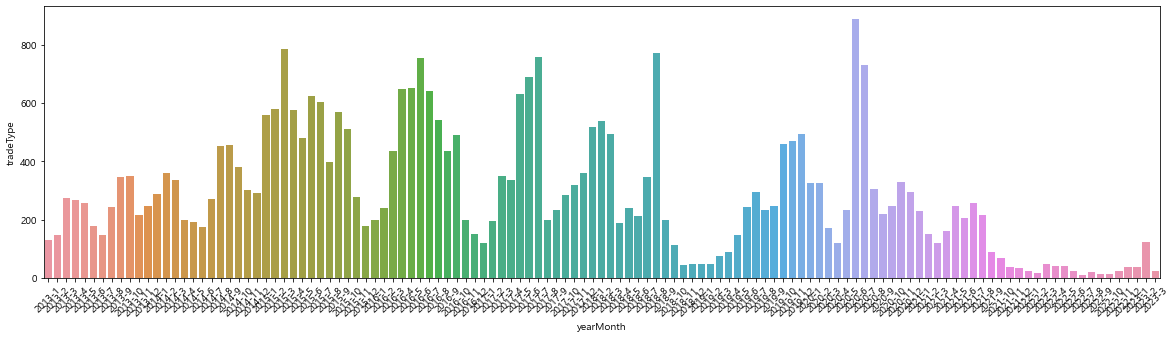

In [6]:
df_tradingYear = df_sigungu[df_sigungu['isReal']==True].groupby('yearMonth')['tradeType'].count().reset_index()
# 연도컬럼 생성
df_tradingYear['year'] = df_tradingYear['yearMonth'].dt.year
# 년-월
df_tradingYear['yearMonth'] = df_tradingYear['yearMonth'].dt.year.astype(str) +'-'+df_tradingYear['yearMonth'].dt.month.astype(str)
# 시각화
plt.figure(figsize = (20, 5))
sns.barplot(df_tradingYear['yearMonth'], df_tradingYear['tradeType'])
plt.xticks(rotation=45)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119]),
 [Text(0, 0, '2013-1'),
  Text(1, 0, '2013-2'),
  Text(2, 0, '2013-3'),
  Text(3, 0, '2013-4'),
  Text(4, 0, '2013-5'),
  Text(5, 0, '2013-6'),
  Text(6, 0, '2013-7'),
  Text(7, 0, '2013-8'),
  Text(8, 0, '2013-9'),
  Text(9, 0, '2013-10'),
  Text(10, 0, '2013-11'),
  Text(11, 0, '2013-12'),
  Text(12, 0, '2014-1'),


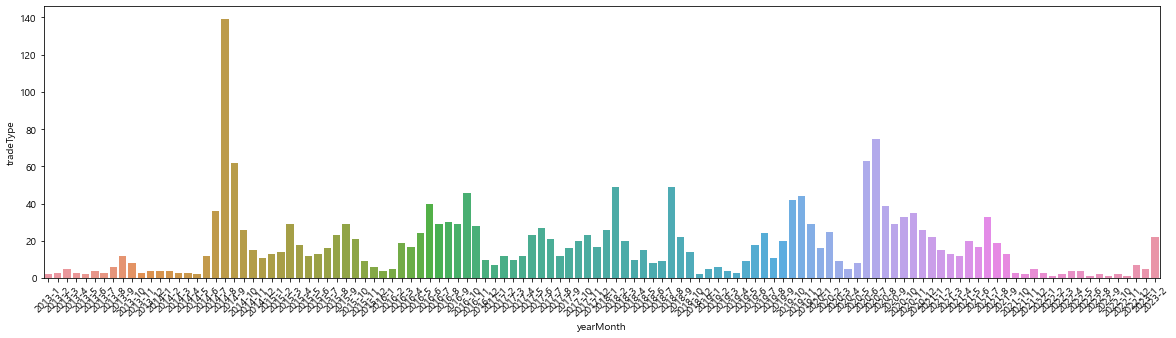

In [7]:
df_tradingYearBdong = df_bdong[df_bdong['isReal']==True].groupby('yearMonth')['tradeType'].count().reset_index()
# 연도컬럼 생성
df_tradingYearBdong['year'] = df_tradingYearBdong['yearMonth'].dt.year
# 년-월
df_tradingYearBdong['yearMonth'] = df_tradingYearBdong['yearMonth'].dt.year.astype(str) +'-'+df_tradingYearBdong['yearMonth'].dt.month.astype(str)
# 시각화
plt.figure(figsize = (20, 5))
sns.barplot(df_tradingYearBdong['yearMonth'], df_tradingYearBdong['tradeType'])
plt.xticks(rotation=45)

## 연간 세대수

<AxesSubplot:xlabel='useApproveYear', ylabel='totalHouseholdCount'>

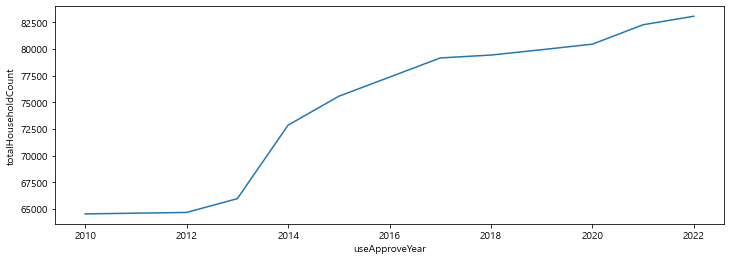

In [8]:
# 실제거래가 된 데이터 추출
df_sigunguReal = df_sigungu[df_sigungu['isReal']==True].drop_duplicates(subset = 'complexNo').reset_index(drop =True)
# 연도별 총 세대수 합계데이터 
df_sigunguSedae = df_sigunguReal.groupby('useApproveYear')['totalHouseholdCount'].sum().reset_index()
# 연도별 누적합 데이터프레임으로 변환
df_sigunguSedaeCount = pd.concat([df_sigunguSedae['useApproveYear'], df_sigunguSedae['totalHouseholdCount'].cumsum()],axis =1)
# 2010년도 이전 데이터 제거
df_sigunguSedaeCount = df_sigunguSedaeCount[df_sigunguSedaeCount['useApproveYear']>='2010'].reset_index(drop =True)
# 타입변경
df_sigunguSedaeCount['useApproveYear'] = df_sigunguSedaeCount['useApproveYear'].astype(int)

plt.figure(figsize = (12, 4))
sns.lineplot(df_sigunguSedaeCount['useApproveYear'], df_sigunguSedaeCount['totalHouseholdCount'])

<AxesSubplot:xlabel='useApproveYear', ylabel='totalHouseholdCount'>

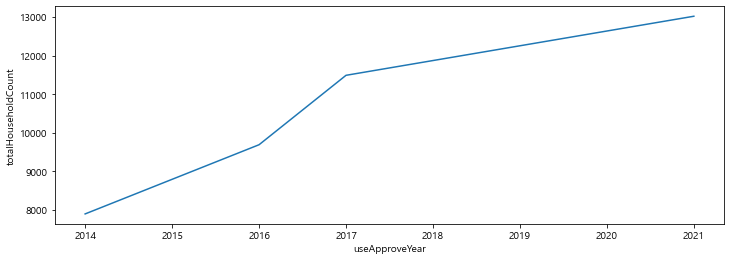

In [9]:
# 실제거래가 된 데이터 추출
df_bdongReal = df_bdong[df_bdong['isReal']==True].drop_duplicates(subset = 'complexNo').reset_index(drop =True)
# 연도별 총 세대수 합계데이터 
df_bdongSedae = df_bdongReal.groupby('useApproveYear')['totalHouseholdCount'].sum().reset_index()
# 연도별 누적합 데이터프레임으로 변환
df_bdongSedaeCount = pd.concat([df_bdongSedae['useApproveYear'], df_bdongSedae['totalHouseholdCount'].cumsum()],axis =1)
# 2010년도 이전 데이터 제거
df_bdongSedaeCount = df_bdongSedaeCount[df_bdongSedaeCount['useApproveYear']>='2010'].reset_index(drop =True)
# 타입변경
df_bdongSedaeCount['useApproveYear'] = df_bdongSedaeCount['useApproveYear'].astype(int)

plt.figure(figsize = (12, 4))
sns.lineplot(df_bdongSedaeCount['useApproveYear'], df_bdongSedaeCount['totalHouseholdCount'])

## 연간 회전율

<AxesSubplot:xlabel='year', ylabel='rotation'>

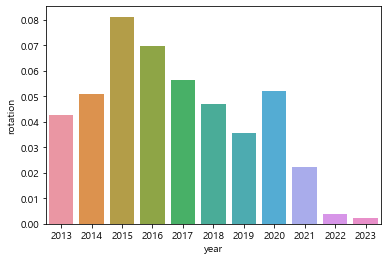

In [10]:
# 연간 거래량 테이블 만들기
df_tradingYear2 = df_tradingYear.groupby('year')['tradeType'].sum().reset_index()
# 연간 총세대수 누적테이블과 merge
df_rotationRatio = pd.merge(df_tradingYear2, df_sigunguSedaeCount, left_on = 'year', right_on = 'useApproveYear', how = 'left')
# 입주물량이없는 연도는 이전연도로 채우기
df_rotationRatio['totalHouseholdCount'] = df_rotationRatio['totalHouseholdCount'].fillna(method = 'ffill')
# 연간회전율 컬럼 만들기
df_rotationRatio['rotation'] = df_rotationRatio['tradeType']/ df_rotationRatio['totalHouseholdCount']
# 시각화
sns.barplot(df_rotationRatio['year'], df_rotationRatio['rotation'])

<AxesSubplot:xlabel='year', ylabel='rotation'>

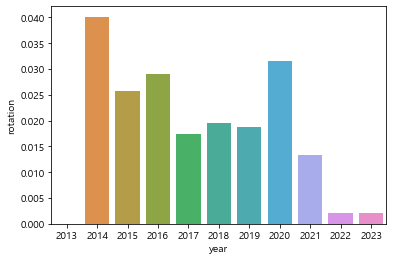

In [11]:
# 연간 거래량 테이블 만들기
df_tradingYearBdong2 = df_tradingYearBdong.groupby('year')['tradeType'].sum().reset_index()
# 연간 총세대수 누적테이블과 merge
df_rotationRatioBdong = pd.merge(df_tradingYearBdong2, df_bdongSedaeCount, left_on = 'year', right_on = 'useApproveYear', how = 'left')
# 입주물량이없는 연도는 이전연도로 채우기
df_rotationRatioBdong['totalHouseholdCount'] = df_rotationRatioBdong['totalHouseholdCount'].fillna(method = 'ffill')
# 연간회전율 컬럼 만들기
df_rotationRatioBdong['rotation'] = df_rotationRatioBdong['tradeType']/ df_rotationRatioBdong['totalHouseholdCount']
# 시각화
sns.barplot(df_rotationRatioBdong['year'], df_rotationRatioBdong['rotation'])

## 면적그룹별 거래량

In [12]:
df_sigungu[df_sigungu['isReal']==True].groupby('areaSixGroupNo')['tradeType'].count().reset_index()

,areaSixGroupNo,tradeType
0,A0,1666
1,A1,5468
2,A2,9373
3,A3,14174
4,A4,2707
5,A5,2256


In [12]:
df_bdong[df_bdong['isReal']==True].groupby('areaSixGroupNo')['tradeType'].count().reset_index()

,areaSixGroupNo,tradeType
0,A2,500
1,A3,1201
2,A4,386


## 면적그룹별 세대수

In [14]:
df_sigungu.drop_duplicates(subset = ['complexNo','areaSixGroupNo']).groupby(['areaSixGroupNo'])['complexName'].count().reset_index()

,areaSixGroupNo,complexName
0,A0,21
1,A1,31
2,A2,120
3,A3,160
4,A4,74
5,A5,24


In [15]:
df_bdong.drop_duplicates(subset = ['complexNo','areaSixGroupNo']).groupby(['areaSixGroupNo'])['complexName'].count().reset_index()

,areaSixGroupNo,complexName
0,A1,1
1,A2,11
2,A3,21
3,A4,12


# 분석

# 상태

In [36]:
df_sigungu.drop_duplicates(subset = 'complexNo').groupby('status')['complexNo'].count().reset_index()

,status,complexNo
0,new,14
1,normal,83
2,old,101


In [41]:
df_bdong.drop_duplicates(subset = 'complexNo').groupby('status')['complexNo'].count().reset_index()

,status,complexNo
0,new,1
1,normal,17
2,old,3


In [7]:
df_status = df_bdong.drop_duplicates(subset = 'complexNo').groupby('status')['complexNo'].count().reset_index().T
df_status.columns = df_status.iloc[0].values
df_status = df_status.drop(index = 'status')
df_status

,new,normal
complexNo,6,6


# 전체거래량 시계열

In [8]:
# 거래량 데이터 프레임
df_trading = df[(df['isReal']==True)|(df['predict']==True)][['complexNo','complexName','areaSixGroupNo','totalHouseholdCount','yearMonth','isReal','predict','averagePyeong','useApproveYear','status']].reset_index(drop =True)
df_sigungu_trading = df_sigungu[(df_sigungu['isReal']==True)|(df['predict']==True)][['complexNo','complexName','areaSixGroupNo','totalHouseholdCount','yearMonth','isReal','predict','averagePyeong','useApproveYear','status']].reset_index(drop =True)
df_bdong_trading = df_bdong[(df_bdong['isReal']==True)|(df_bdong['predict']==True)][['complexNo','complexName','areaSixGroupNo','totalHouseholdCount','yearMonth','isReal','predict','averagePyeong','useApproveYear','status']].reset_index(drop =True)

In [9]:
# 월별 거래량 변화
df_viz_sido = df_trading[df_trading['isReal']==True].groupby('yearMonth')['complexNo'].count().reset_index()
df_viz_sigungu = df_sigungu_trading[df_sigungu_trading['isReal']==True].groupby('yearMonth')['complexNo'].count().reset_index()
df_viz_bdong = df_bdong_trading[df_bdong_trading['isReal']==True].groupby('yearMonth')['complexNo'].count().reset_index()

<AxesSubplot:xlabel='yearMonth', ylabel='complexNo'>

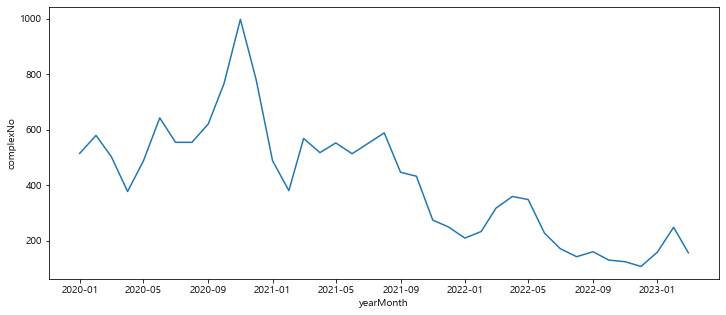

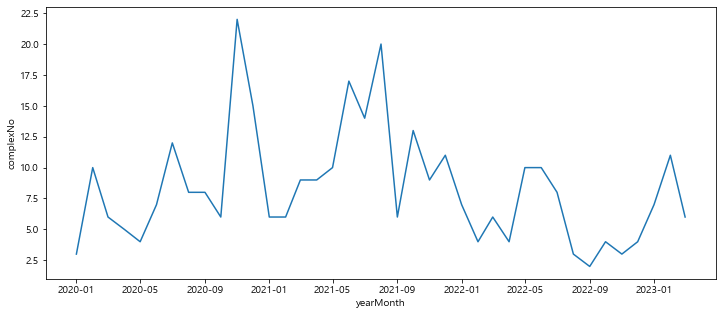

In [10]:
plt.figure(figsize = (12, 5))
sns.lineplot(df_viz_sigungu['yearMonth'], df_viz_sigungu['complexNo'])
plt.figure(figsize = (12, 5))
sns.lineplot(df_viz_bdong['yearMonth'], df_viz_bdong['complexNo'])

# 면적 구간별 거래량

In [11]:
# 시군구
df_sigungu_trading[df_sigungu_trading['isReal']==True].groupby('areaSixGroupNo').count().reset_index().sort_values(by = 'complexNo', ascending = False).reset_index(drop =True)[['areaSixGroupNo','complexNo']]

,areaSixGroupNo,complexNo
0,A3,8226
1,A2,4305
2,A1,2033
3,A4,786
4,A5,419
5,A0,249


In [12]:
# 법정동
df_bdong_trading[df_bdong_trading['isReal']==True].groupby('areaSixGroupNo').count().reset_index().sort_values(by = 'complexNo',ascending = False).reset_index(drop =True)[['areaSixGroupNo','complexNo']]

,areaSixGroupNo,complexNo
0,A3,147
1,A1,113
2,A0,58
3,A4,7


# 신,구축,일반 단지당 거래량

- 갯수당 거래량??? 신축의 갯수가 시군구 혹은 법정동이 다르기때문에 ->갯수당이 아닌 세대당 거래량  = 회전율

## 법정동 전체 회전율

연도별로 총세대수가 다르다

In [13]:
bSeade = df_bdong.drop_duplicates(subset = 'complexNo')['totalHouseholdCount'].sum()

In [14]:
df_bdong_trading

,complexNo,complexName,areaSixGroupNo,totalHouseholdCount,yearMonth,isReal,predict,averagePyeong,useApproveYear,status
0,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2020-07-01,True,False,1.263090e+07,2017,normal
1,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2021-03-01,True,False,1.451180e+07,2017,normal
2,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2020-09-01,True,False,1.237492e+07,2017,normal
3,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2020-11-01,True,False,1.243878e+07,2017,normal
4,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2020-06-01,True,False,1.256857e+07,2017,normal
...,...,...,...,...,...,...,...,...,...,...
337,114300,힐스테이트리버파크(주상복합),A3,1111,2023-02-01,True,False,1.899815e+07,2019,new
338,114300,힐스테이트리버파크(주상복합),A4,1111,2022-10-01,True,False,2.432688e+07,2019,new
339,117783,에이엠시티4차(도시형),A0,102,2023-04-01,False,True,5.828635e+06,2014,normal
340,117783,에이엠시티4차(도시형),A0,102,2023-01-01,True,False,5.377808e+06,2014,normal


In [15]:
df_status2 = pd.DataFrame(df_bdong_trading[df_trading['isReal']==True].groupby('status')['complexNo'].count()).reset_index().T

In [16]:
df_status2.columns = df_status2.iloc[0].values
df_status2 = df_status2.drop(index = 'status')

In [17]:
df_result = df_status2/df_status
df_result

,new,normal
complexNo,13.166667,42.5


# 대장단지

- 신,구축,일반 평단가 평균

In [18]:
df_bdong_trading[df_bdong_trading['yearMonth']=='2023-03-01'].groupby('status')['averagePyeong'].mean().reset_index()

,status,averagePyeong
0,new,19538015.25
1,normal,13884351.50


- 현재 예측가격 기준 ToP5단지

In [19]:
df_bdong_trading[df_bdong_trading['yearMonth']=='2023-03-01'].sort_values(by ='averagePyeong',ascending = False).reset_index(drop = True).iloc[:5]

,complexNo,complexName,areaSixGroupNo,totalHouseholdCount,yearMonth,isReal,predict,averagePyeong,useApproveYear,status
0,114300,힐스테이트리버파크(주상복합),A3,1111,2023-03-01,True,False,19538015.25,2019,new
1,114300,힐스테이트리버파크(주상복합),A3,1111,2023-03-01,True,False,19538015.25,2019,new
2,114300,힐스테이트리버파크(주상복합),A3,1111,2023-03-01,True,False,19538015.25,2019,new
3,114300,힐스테이트리버파크(주상복합),A3,1111,2023-03-01,True,False,19538015.25,2019,new
4,108894,쌍암중흥S-클래스리버시티(주상복합),A3,406,2023-03-01,True,False,13884351.50,2017,normal
